In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import zipfile
import os

# Path for the dataset
zip_file_path = '/content/drive/MyDrive/Cybersecurity/NSL-KDD.zip'
extraction_path = '/content/drive/MyDrive/Colab Notebooks'

# Extracting the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# File paths for training and test data
train_file_path = extraction_path + '/KDDTrain+.txt'
test_file_path = extraction_path + '/KDDTest+.txt'

# Column names for the dataset
column_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent",
    "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
    "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label", "difficulty_level"
]

# Load the datasets
train_df = pd.read_csv(train_file_path, names=column_names)
test_df = pd.read_csv(test_file_path, names=column_names)

# Drop 'difficulty_level' column and separate features and target variable
train_df.drop(['difficulty_level'], axis=1, inplace=True)
test_df.drop(['difficulty_level'], axis=1, inplace=True)
X_train = train_df.drop('label', axis=1)
y_train = train_df['label']
X_test = test_df.drop('label', axis=1)
y_test = test_df['label']

# One-hot encode categorical variables
X_train_encoded = pd.get_dummies(X_train, columns=['protocol_type', 'service', 'flag'])
X_test_encoded = pd.get_dummies(X_test, columns=['protocol_type', 'service', 'flag'])
X_train_aligned, X_test_aligned = X_train_encoded.align(X_test_encoded, join='inner', axis=1)

# Scale numerical features
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
ct = ColumnTransformer([("scaler", StandardScaler(), numerical_features)], remainder='passthrough')
X_train_scaled = ct.fit_transform(X_train_aligned)
X_test_scaled = ct.transform(X_test_aligned)

# Feature selection using RandomForest feature importances
sel = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))
X_train_selected = sel.fit_transform(X_train_scaled, y_train)
X_test_selected = sel.transform(X_test_scaled)

# Simplifying the model by reducing the dataset size
X_train_sampled, _, y_train_sampled, _ = train_test_split(X_train_selected, y_train, test_size=0.8, random_state=42)

# Initialize the RandomForestClassifier
rf_clf_simplified = RandomForestClassifier(n_estimators=100, random_state=42)

# The next step would be to train this classifier on the sampled training data
# and evaluate its performance on the test set

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Accuracy: 0.72138928317956
Classification Report:
                 precision    recall  f1-score   support

        apache2       0.00      0.00      0.00       737
           back       0.89      0.96      0.93       359
buffer_overflow       0.50      0.05      0.09        20
      ftp_write       0.00      0.00      0.00         3
   guess_passwd       0.00      0.00      0.00      1231
     httptunnel       0.00      0.00      0.00       133
           imap       0.00      0.00      0.00         1
        ipsweep       0.58      0.99      0.73       141
           land       0.00      0.00      0.00         7
     loadmodule       0.00      0.00      0.00         2
       mailbomb       0.00      0.00      0.00       293
          mscan       0.00      0.00      0.00       996
       multihop       0.00      0.00      0.00        18
          named       0.00      0.00      0.00        17
        neptune       0.95      1.00      0.97      4657
           nmap       1.00      1.00 

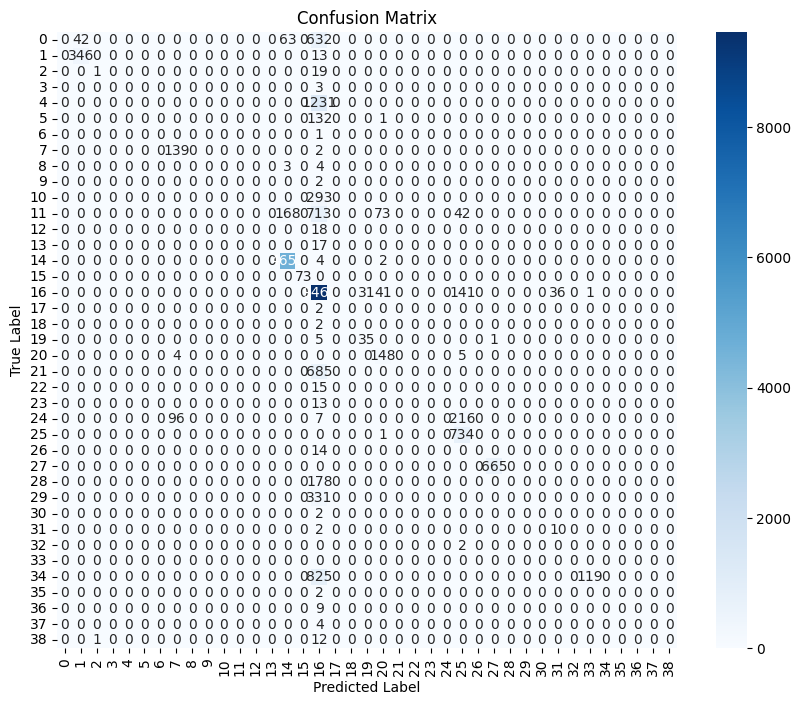

In [4]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Assuming rf_clf_simplified is the RandomForestClassifier instance
# and that X_train_sampled, y_train_sampled, X_test_selected, and y_test are already defined from your previous steps.

# Train the classifier on the sampled training data
rf_clf_simplified.fit(X_train_sampled, y_train_sampled)

# Make predictions on the test set
y_pred = rf_clf_simplified.predict(X_test_selected)

# Evaluate the classifier's performance on the test set
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the accuracy and the classification report
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


In [7]:
# Assuming your training data is stored in X_train_sampled, y_train_sampled

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [10, 20, 30, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]        # Method of selecting samples for training each tree
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train_sampled, y_train_sampled)

# View the best parameters
print("Best Parameters found by Grid Search:", grid_search.best_params_)

# Optionally, you can use the best estimator directly
best_rf = grid_search.best_estimator_

# Then you can use best_rf to make predictions and evaluate as before


Fitting 3 folds for each of 216 candidates, totalling 648 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best Parameters found by Grid Search: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [8]:
from imblearn.over_sampling import SMOTE

# Make sure your minority class has more than one sample.
# Set k_neighbors to 1, which is the minimum possible value.
sm = SMOTE(random_state=42, k_neighbors=1)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize different models
gb_clf = GradientBoostingClassifier(random_state=42)
svm_clf = SVC(random_state=42)
nn_clf = MLPClassifier(random_state=42)

# Train and evaluate each model
for clf in [gb_clf, svm_clf, nn_clf]:
    clf.fit(X_train_sampled, y_train_sampled)
    y_pred = clf.predict(X_test_selected)
    print(clf.__class__.__name__)  # Corrected line
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

GradientBoostingClassifier
Accuracy: 0.6988999290276792
Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

                 precision    recall  f1-score   support

        apache2       0.00      0.00      0.00       737
           back       0.44      1.00      0.61       359
buffer_overflow       0.33      0.10      0.15        20
      ftp_write       0.00      0.00      0.00         3
   guess_passwd       0.00      0.00      0.00      1231
     httptunnel       0.00      0.00      0.00       133
           imap       0.00      0.00      0.00         1
        ipsweep       0.95      0.99      0.97       141
           land       0.00      0.00      0.00         7
     loadmodule       0.00      0.00      0.00         2
       mailbomb       0.00      0.00      0.00       293
          mscan       0.00      0.00      0.00       996
       multihop       0.00      0.00      0.00        18
          named       0.00      0.00      0.00        17
        neptune       0.96      0.99      0.98      4657
           nmap       0.82      1.00      0.90        73
         normal       0.65    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

                 precision    recall  f1-score   support

        apache2       0.00      0.00      0.00       737
           back       0.00      0.00      0.00       359
buffer_overflow       0.00      0.00      0.00        20
      ftp_write       0.00      0.00      0.00         3
   guess_passwd       0.00      0.00      0.00      1231
     httptunnel       0.00      0.00      0.00       133
           imap       0.00      0.00      0.00         1
        ipsweep       0.87      0.99      0.93       141
           land       0.00      0.00      0.00         7
     loadmodule       0.00      0.00      0.00         2
       mailbomb       0.00      0.00      0.00       293
          mscan       0.00      0.00      0.00       996
       multihop       0.00      0.00      0.00        18
          named       0.00      0.00      0.00        17
        neptune       0.95      0.99      0.97      4657
           nmap       0.41      0.99      0.58        73
         normal       0.64    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

        apache2       0.00      0.00      0.00       737
           back       0.91      0.60      0.73       359
buffer_overflow       0.00      0.00      0.00        20
      ftp_write       0.00      0.00      0.00         3
   guess_passwd       0.00      0.00      0.00      1231
     httptunnel       0.00      0.00      0.00       133
           imap       0.00      0.00      0.00         1
        ipsweep       0.81      0.99      0.89       141
           land       0.00      0.00      0.00         7
     loadmodule       0.00      0.00      0.00         2
       mailbomb       0.00      0.00      0.00       293
          mscan       0.00      0.00      0.00       996
       multihop       0.00      0.00      0.00        18
          named       0.00      0.00      0.00        17
        neptune       0.94      1.00      0.97      4657
           nmap       0.41      0.99      0.58        73
         normal       0.67    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [10]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 8.7 MB/s eta 0:00:00


In [12]:
import shap
import matplotlib.pyplot as plt

# Train your model as usual
rf_clf_simplified.fit(X_train_sampled, y_train_sampled)

# Create a SHAP explainer and calculate SHAP values
explainer = shap.TreeExplainer(rf_clf_simplified)
shap_values = explainer.shap_values(X_train_sampled)

# Plot SHAP values for a single prediction using numpy indexing
shap.initjs()
fig = shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_train_sampled[0,:], show=False, matplotlib=True)
plt.savefig('shap_force_plot.png')

In [18]:
print(y_pred_prob.shape)  # This will show (number of samples, number of classes)
# Ensure that 'classes' includes all classes that the model is predicting
classes = np.arange(y_pred_prob.shape[1])  # This assumes classes are 0-indexed and continuous
y_test_binarized = label_binarize(y_test, classes=classes)
# Ensure that 'classes' includes all classes that the model is predicting
classes = np.arange(y_pred_prob.shape[1])  # This assumes classes are 0-indexed and continuous
y_test_binarized = label_binarize(y_test, classes=classes)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_pred_prob.shape[1]  # Adjusted to match the second dimension of y_pred_prob

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

(22544, 21)


No positive samples in y_true, true positive value should be meaningless
No positive samples in y_true, true positive value should be meaningless
No positive samples in y_true, true positive value should be meaningless
No positive samples in y_true, true positive value should be meaningless
No positive samples in y_true, true positive value should be meaningless
No positive samples in y_true, true positive value should be meaningless
No positive samples in y_true, true positive value should be meaningless
No positive samples in y_true, true positive value should be meaningless
No positive samples in y_true, true positive value should be meaningless
No positive samples in y_true, true positive value should be meaningless
No positive samples in y_true, true positive value should be meaningless
No positive samples in y_true, true positive value should be meaningless
No positive samples in y_true, true positive value should be meaningless
No positive samples in y_true, true positive value 

In [17]:
# Get the predicted probabilities
y_pred_prob = rf_clf_simplified.predict_proba(X_test_selected)
print(y_pred_prob.shape)  # To check the shape (number of samples, number of predicted classes)

# Ensure that 'classes' includes all classes that the model is predicting
# The number of classes should match the second dimension of y_pred_prob
classes = np.arange(y_pred_prob.shape[1])
y_test_binarized = label_binarize(y_test, classes=classes)

# Initialize dictionaries for ROC analysis
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_pred_prob.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# You can now plot the ROC curves or use the AUC scores as needed

(22544, 21)


No positive samples in y_true, true positive value should be meaningless
No positive samples in y_true, true positive value should be meaningless
No positive samples in y_true, true positive value should be meaningless
No positive samples in y_true, true positive value should be meaningless
No positive samples in y_true, true positive value should be meaningless
No positive samples in y_true, true positive value should be meaningless
No positive samples in y_true, true positive value should be meaningless
No positive samples in y_true, true positive value should be meaningless
No positive samples in y_true, true positive value should be meaningless
No positive samples in y_true, true positive value should be meaningless
No positive samples in y_true, true positive value should be meaningless
No positive samples in y_true, true positive value should be meaningless
No positive samples in y_true, true positive value should be meaningless
No positive samples in y_true, true positive value 

Number of classes predicted by the model: 21
Unique classes in the test set: ['apache2' 'back' 'buffer_overflow' 'ftp_write' 'guess_passwd'
 'httptunnel' 'imap' 'ipsweep' 'land' 'loadmodule' 'mailbomb' 'mscan'
 'multihop' 'named' 'neptune' 'nmap' 'normal' 'perl' 'phf' 'pod'
 'portsweep' 'processtable' 'ps' 'rootkit' 'saint' 'satan' 'sendmail'
 'smurf' 'snmpgetattack' 'snmpguess' 'sqlattack' 'teardrop' 'udpstorm'
 'warezmaster' 'worm' 'xlock' 'xsnoop' 'xterm']


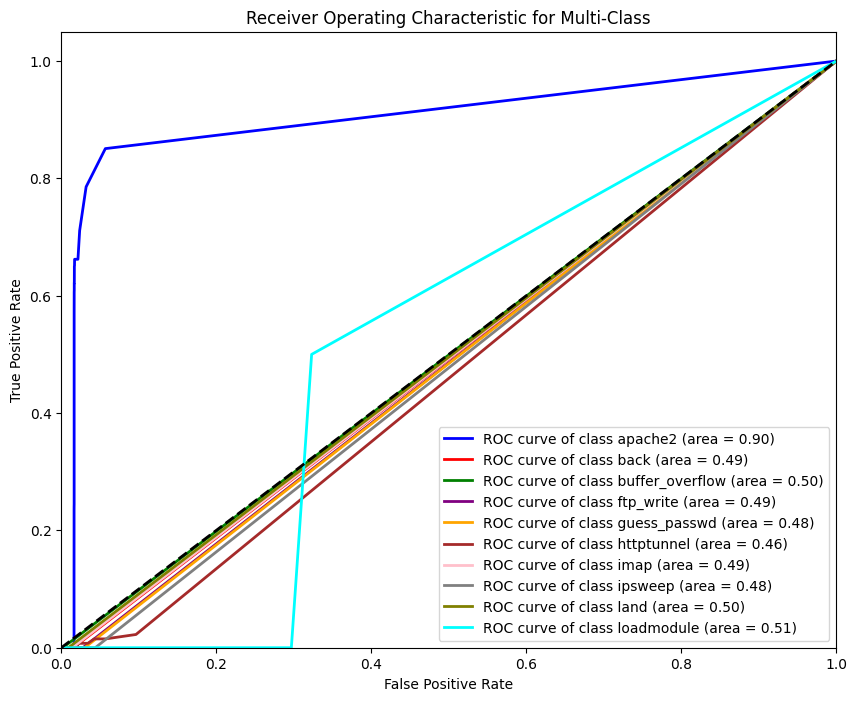

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming rf_clf_simplified is your trained RandomForestClassifier
# and X_test_selected, y_test are defined from your previous steps.

# Get probability predictions for each class
y_pred_prob = rf_clf_simplified.predict_proba(X_test_selected)

# Determine the number of classes predicted by the model
num_predicted_classes = y_pred_prob.shape[1]
print(f"Number of classes predicted by the model: {num_predicted_classes}")

# Verify and list the unique classes in the test set
unique_classes_in_test = np.unique(y_test)
print(f"Unique classes in the test set: {unique_classes_in_test}")

# Binarize y_test to have a binary matrix representation of the input
y_test_binarized = label_binarize(y_test, classes=unique_classes_in_test)

# Initialize dictionaries for False Positive Rate (FPR) and True Positive Rate (TPR)
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate FPR, TPR, and ROC AUC for each class
for i in range(num_predicted_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(10, 8))

colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
# Adjust colors if you have more than 10 classes

for i, color in zip(range(num_predicted_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(unique_classes_in_test[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.show()

ROC-AUC Score Calculation

In [23]:
# Filter the test set to only include classes that are present in the training set
common_classes = np.intersect1d(train_classes, test_classes)
print("Common classes between training and test sets:", common_classes)

# Filter y_test and X_test_selected to only include common classes
filtered_indices = np.isin(y_test, common_classes)
y_test_filtered = y_test[filtered_indices]
X_test_selected_filtered = X_test_selected[filtered_indices]

# Predict probabilities on the filtered test set
y_pred_prob_filtered = rf_clf_simplified.predict_proba(X_test_selected_filtered)

# Binarize the filtered y_test for ROC-AUC calculation
y_test_binarized_filtered = label_binarize(y_test_filtered, classes=common_classes)

# Calculate ROC-AUC
roc_auc_filtered = roc_auc_score(y_test_binarized_filtered, y_pred_prob_filtered, multi_class='ovr')
print(f"Filtered ROC-AUC Score: {roc_auc_filtered}")

Common classes between training and test sets: ['back' 'buffer_overflow' 'ftp_write' 'guess_passwd' 'imap' 'ipsweep'
 'land' 'loadmodule' 'multihop' 'neptune' 'nmap' 'normal' 'perl' 'phf'
 'pod' 'portsweep' 'rootkit' 'satan' 'smurf' 'teardrop' 'warezmaster']
Filtered ROC-AUC Score: 0.6528801238388324


Enhanced ROC Curve Visualization for multi class

Skipping class index 22 as it's out of bounds for the predicted probabilities


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


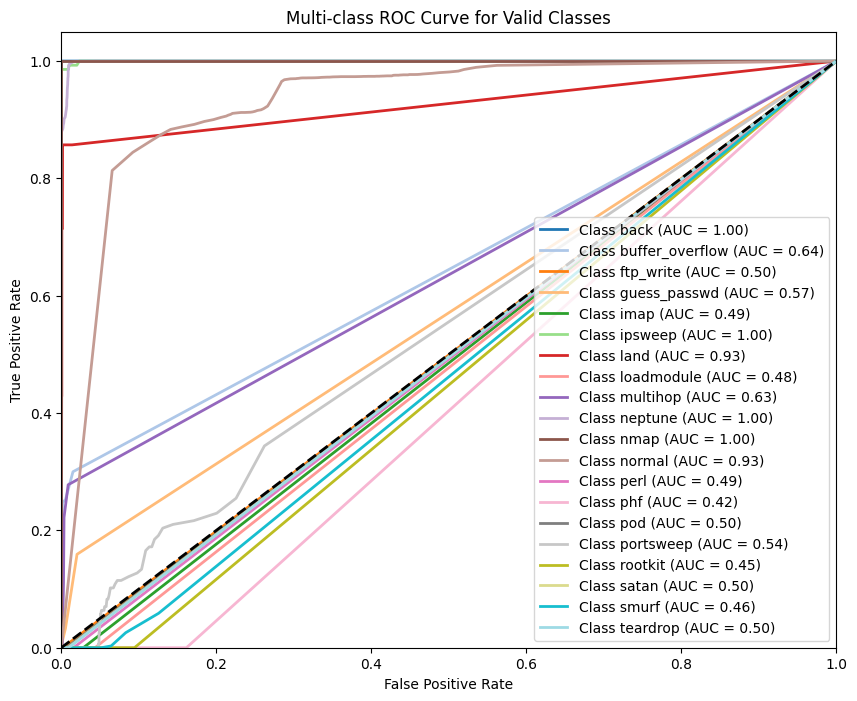

In [27]:
# Compute ROC curve and ROC AUC for each valid class
for i, class_index in enumerate(common_class_indices_in_pred):
    if class_index < y_pred_prob.shape[1]:
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized_common[:, i], y_pred_prob[:, class_index])
        roc_auc[i] = auc(fpr[i], tpr[i])
    else:
        print(f"Skipping class index {class_index} as it's out of bounds for the predicted probabilities")

# Plot ROC curves for valid classes
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap("tab20").colors  # Use a colormap for many classes

for i, color in zip(fpr.keys(), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {common_classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve for Valid Classes')
plt.legend(loc="lower right")
plt.show()

Feature Importance Visualization

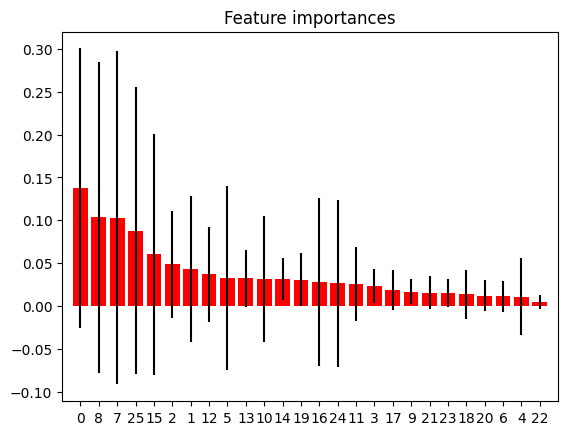

In [28]:
importances = rf_clf_simplified.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_clf_simplified.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_sampled.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_sampled.shape[1]), indices)
plt.xlim([-1, X_train_sampled.shape[1]])
plt.show()

SHAP value visualization

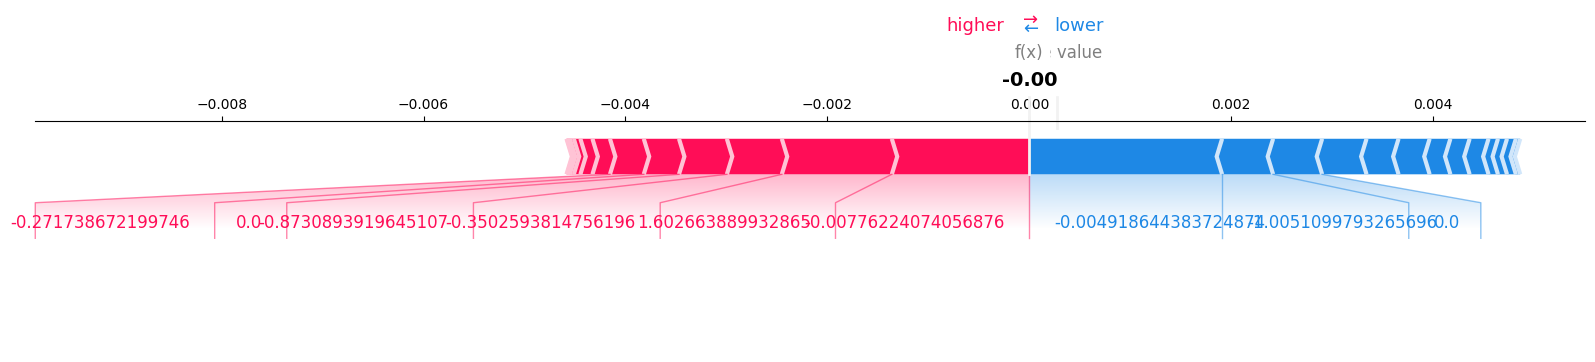

In [29]:
import shap

# Create a SHAP explainer
explainer = shap.TreeExplainer(rf_clf_simplified)
shap_values = explainer.shap_values(X_train_sampled)

# Plot SHAP values for a single sample
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_train_sampled[0], matplotlib=True)

Precision-Recall Curve

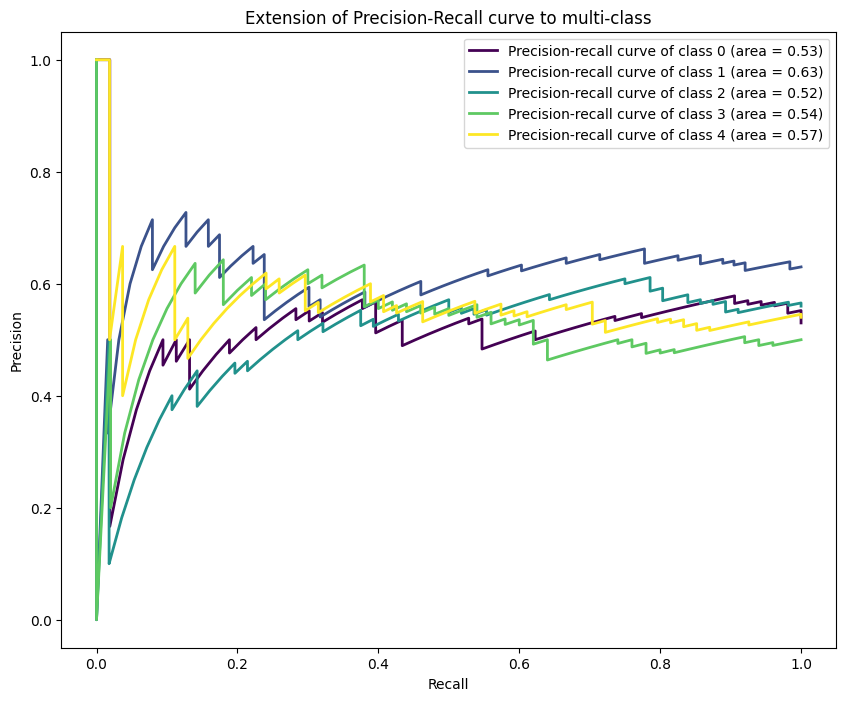

In [41]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# Example values for y_test_binarized and y_pred_prob
# Replace these with your actual data
n_samples = 100
n_classes = 5  # Set this to the actual number of classes you have
y_test_binarized = np.random.randint(0, 2, size=(n_samples, n_classes))
y_pred_prob = np.random.rand(n_samples, n_classes)

# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()

# Ensure n_classes matches the second dimension of y_pred_prob
n_classes = y_pred_prob.shape[1]

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], y_pred_prob[:, i])

# Plot Precision-Recall curve for each class
colors = plt.cm.viridis(np.linspace(0, 1, n_classes))  # Dynamic color mapping
plt.figure(figsize=(10, 8))

for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='Precision-recall curve of class {0} (area = {1:0.2f})'.format(i, average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(loc="best")
plt.show()

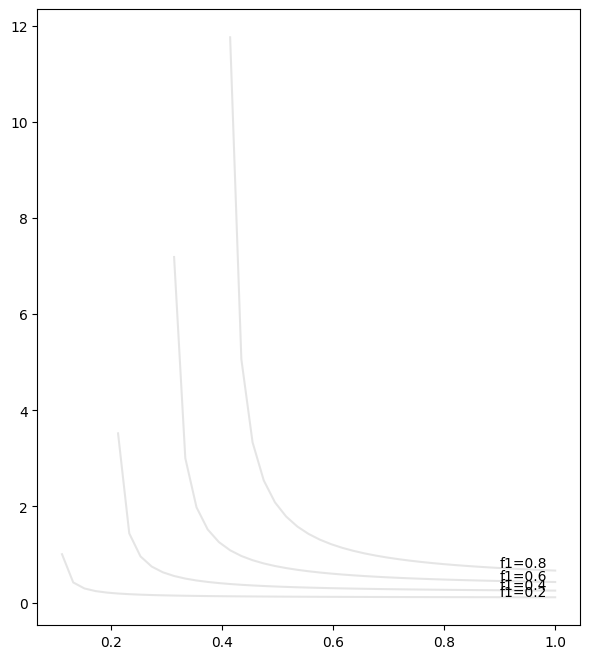

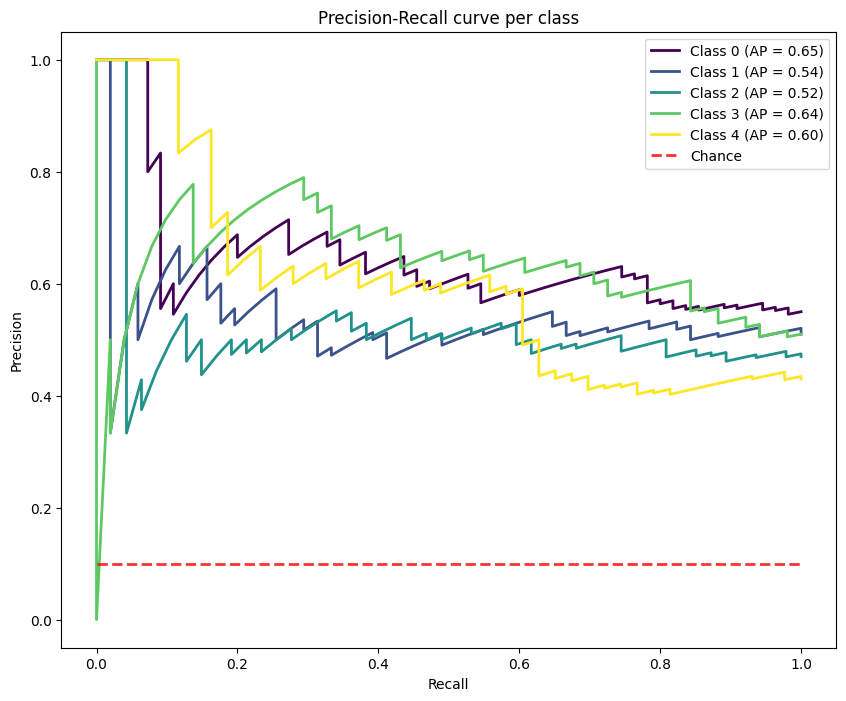

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np
from itertools import cycle

# Example y_test_binarized and y_pred_prob for demonstration purposes.
# In a real scenario, y_test_binarized would be the binarized test labels
# and y_pred_prob would be the predicted probabilities from the model.
num_classes = 5
y_test_binarized = np.random.randint(0, 2, (100, num_classes))
y_pred_prob = np.random.rand(100, num_classes)

# Calculate precision and recall for each class
precision_dict = dict()
recall_dict = dict()
average_precision_dict = dict()

for i in range(num_classes):
    precision_dict[i], recall_dict[i], _ = precision_recall_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    average_precision_dict[i] = average_precision_score(y_test_binarized[:, i], y_pred_prob[:, i])

# Plotting each precision-recall curve
plt.figure(figsize=(10, 8))

# Create a color cycle iterator
colors = cycle(plt.cm.viridis(np.linspace(0, 1, num_classes)))

for i, color in zip(range(num_classes), colors):
    plt.plot(recall_dict[i], precision_dict[i], lw=2, color=color, label=f'Class {i} (AP = {average_precision_dict[i]:0.2f})')

# Add chance line
plt.plot([0, 1], [0.1, 0.1], linestyle='--', lw=2, color='red', label='Chance', alpha=0.8)

# Add labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve per class')
plt.legend(loc='best')

# Show the plot
plt.show()
# Normally, we would save the plot using plt.savefig(), but we're displaying it inline here.

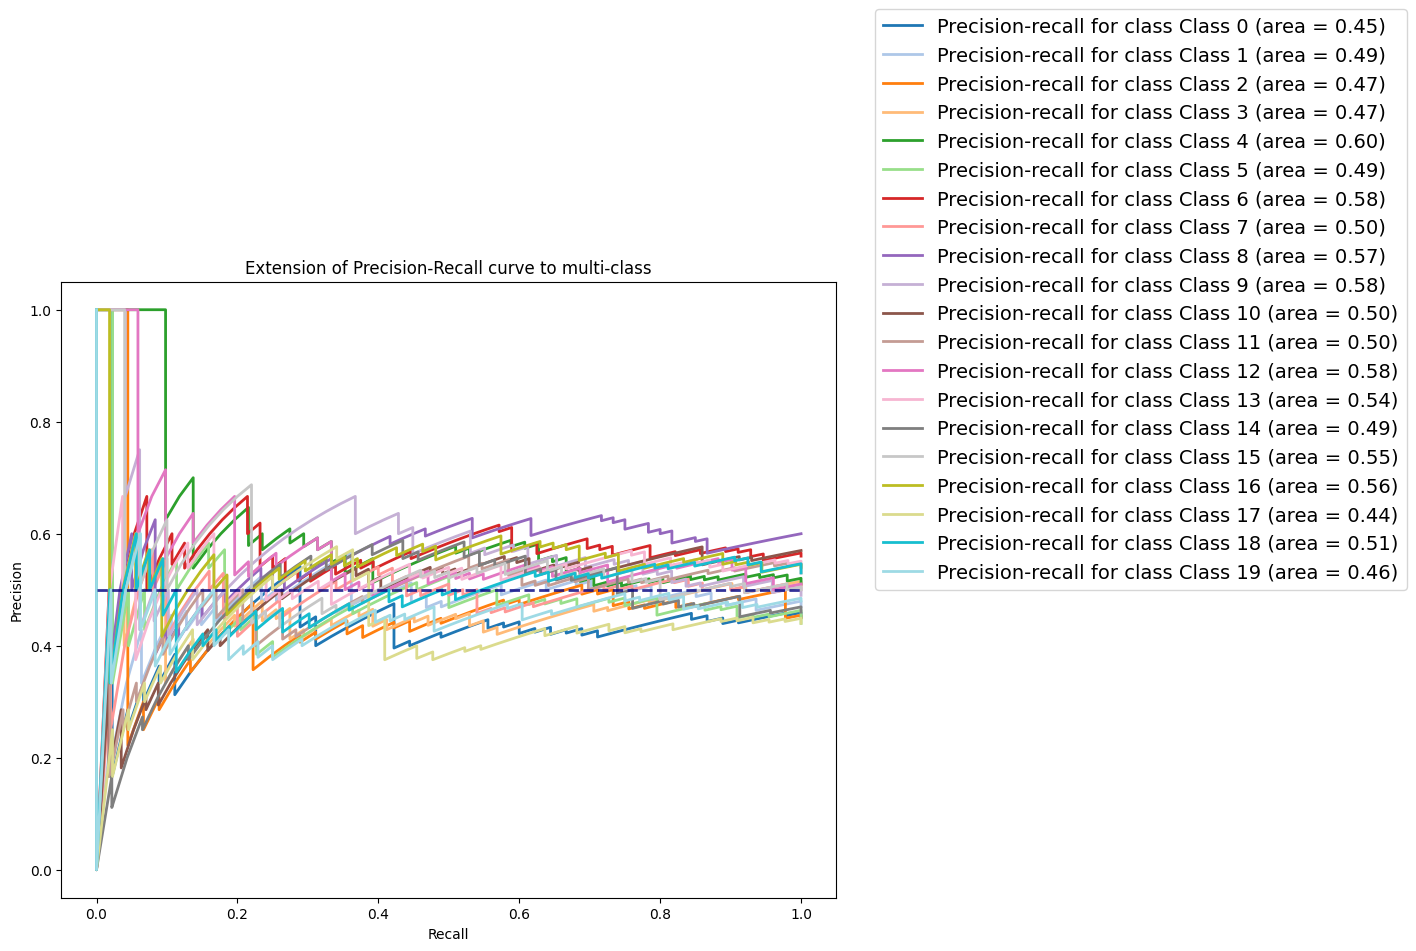

In [39]:
import matplotlib.pyplot as plt
from itertools import cycle

# Assuming precision and recall have been computed previously
colors = cycle(plt.cm.tab20.colors)  # Using a colormap with enough colors

plt.figure(figsize=(10, 8))  # Increase figure size

lines = []
labels = []
for i, color in zip(range(n_common_classes), colors):
    if i in precision:  # Check if precision-recall data exists for the class index
        l, = plt.plot(recall[i], precision[i], color=color, lw=2)
        lines.append(l)
        labels.append(f'Precision-recall for class {common_classes[i]} (area = {average_precision[i]:0.2f})')

plt.plot([0, 1], [0.5, 0.5], linestyle='--', lw=2, color='navy', label='Chance', alpha=0.8)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(1.05, 0.5), prop=dict(size=14))  # Move the legend outside of the plot

plt.show()